[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/trixi_comparison/advection_comparison.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyMPDATA.git/main?urlpath=lab/tree/examples/PyMPDATA_examples/trixi_comparison/advection_comparison.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/trixi_comparison/advection_comparison.ipynb)

# Introduction
Trixi.jl is a numerical simulation framework for conservation laws written in Julia. It is based on the Discontinuous Galerkin (DG) method and for the purpose of this comparison, we will use the StructuredMesh for data representation.

This notebook compares the results of a simple advection equation solved in 2D by PyMPDATA and Trixi.jl.
The general flow of the notebook is as follows:
1. We define the advection equation and the common settings for both PyMPDATA and Trixi.jl in the JSON file.
2. We run the simulation in Trixi.jl and save the results.
3. We use Trixi2Vtk to convert the results to a vtk file.
4. We reshape the results from Trixi.jl to match the shape of the results from PyMPDATA.
5. We run the simulation in PyMPDATA for a bigger nx and ny, to account for the polynomial degree in Trixi.jl. 
6. We compare the results from PyMPDATA and Trixi.jl.
7. We assert that the results are close to each other, this is to ensure that the implementation of PyMPDATA is correct.

To run the notebook, Julia and the following Julia packages are required:
- JSON
- Trixi
- OrdinaryDiffEq
- Trixi2Vtk
- Pkg

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

In [ ]:
if 'google.colab' in sys.modules:
    JULIA_URL = "https://julialang-s3.julialang.org/bin/linux/x64/1.11/julia-1.11.1-linux-x86_64.tar.gz"
    !wget -nv $JULIA_URL -O /tmp/julia.tar.gz
    !tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    !rm /tmp/julia.tar.gz

## common settings

In [2]:
SETUP = {
    "nx": 32,
    "ny": 32,
    "ux": 0.25,
    "uy": 0.25,
    "dt": 0.025,
    "tmax": 2.0,
    "polydeg": 2,
    "omega": 3.141592,
    "min_x": -1.0,
    "min_y": -1.0,
    "max_x": 1.0,
    "max_y": 1.0
}

assert SETUP["nx"] == SETUP["ny"]

import json
import subprocess
with open('setup.json', 'w', encoding='UTF-8') as f:
    json.dump(SETUP, f)

## Trixi.jl

In [3]:
%%writefile trixi.jl
import Pkg
Pkg.add(["JSON", "Trixi", "OrdinaryDiffEq", "Trixi2Vtk"])
using JSON
using Trixi
using OrdinaryDiffEq
using Trixi2Vtk

setup = JSON.parsefile("./setup.json")

advection_velocity = (setup["ux"], setup["uy"])
equations = LinearScalarAdvectionEquation2D(advection_velocity)
solver = DGSEM(polydeg = setup["polydeg"])

function initial_condition(x, t, equations::LinearScalarAdvectionEquation2D)
    return SVector(sin(setup["omega"]*sum(x)) + 1)
end

cells_per_dimension = (setup["nx"], setup["ny"])
coordinates_min = (setup["min_x"], setup["min_y"])
coordinates_max = (setup["max_x"], setup["max_y"])

mesh = StructuredMesh(cells_per_dimension, coordinates_min, coordinates_max)
semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition, solver)

tspan = (0.0, setup["tmax"])
ode = semidiscretize(semi, tspan);

summary_callback = SummaryCallback()
save_solution = SaveSolutionCallback(save_initial_solution = false, interval=100)

stepsize_callback = StepsizeCallback(cfl = 1.6)

callbacks = CallbackSet(summary_callback, save_solution, stepsize_callback)

time_int_tol = 1e-6
sol = solve(ode, CarpenterKennedy2N54();
            abstol = time_int_tol,
            reltol = time_int_tol,
            dt = setup["dt"],
            ode_default_options()..., callback = callbacks);

summary_callback()

Overwriting trixi.jl


In [4]:
subprocess.run(["julia", "trixi.jl"], check=True)

CompletedProcess(args=['julia', 'trixi.jl'], returncode=0)

## PyMPDATA

In [5]:
import numpy as np
import meshio
from open_atmos_jupyter_utils import show_plot
import matplotlib.pyplot as plt
from PyMPDATA import Solver, ScalarField, VectorField, Stepper, Options
from PyMPDATA.boundary_conditions import Periodic
import os

In [6]:
dt = SETUP["dt"]
tmax = SETUP["tmax"]
nt = int(tmax / dt)

nx = SETUP["nx"] * SETUP["polydeg"] + 1
ny = SETUP["ny"] * SETUP["polydeg"] + 1
ux  = SETUP["ux"]
uy = SETUP["uy"]
omega = SETUP["omega"]

min_x, min_y = SETUP["min_x"], SETUP["min_y"]
max_x, max_y = SETUP["max_x"], SETUP["max_y"]
dx_temp = (max_x - min_x) / (nx - 1)
dy_temp = (max_y - min_y) / (ny - 1)
min_x, max_x = min_x - dx_temp/2, max_x + dx_temp/2
min_y, max_y = min_y - dy_temp/2, max_y + dy_temp/2
dx = (max_x - min_x) / nx
dy = (max_y - min_y) / ny
Cx = ux * dt / dx
Cy = uy * dt / dy

In [7]:
opt = Options(n_iters=3)
boundary_conditions = (Periodic(), Periodic())

In [8]:
def initial_condition():
    return np.array(
    [
        np.sin(omega*(x+y)) + 1 for x in np.linspace(min_x, max_x, nx)
        for y in np.linspace(min_y, max_y, ny)
    ],
    dtype=float
).reshape((nx, ny))

advectee = ScalarField(data=initial_condition(), halo=opt.n_halo, boundary_conditions=boundary_conditions)

In [9]:
field_x = np.full((nx+1, ny), Cx, dtype=opt.dtype)
field_y = np.full((nx, ny+1), Cy, dtype=opt.dtype)

advector = VectorField(
    data=(field_x, field_y),
    halo=opt.n_halo,
    boundary_conditions=(boundary_conditions[0], Periodic())
)

In [10]:
stepper = Stepper(options=opt, n_dims=2)
solver = Solver(stepper=stepper, advector=advector, advectee=advectee)

In [11]:
vmin = np.min(solver.advectee.get())
vmax = np.max(solver.advectee.get())

In [12]:
_ = solver.advance(n_steps=nt)

In [13]:
pympdata_result_state = solver.advectee.get().copy()

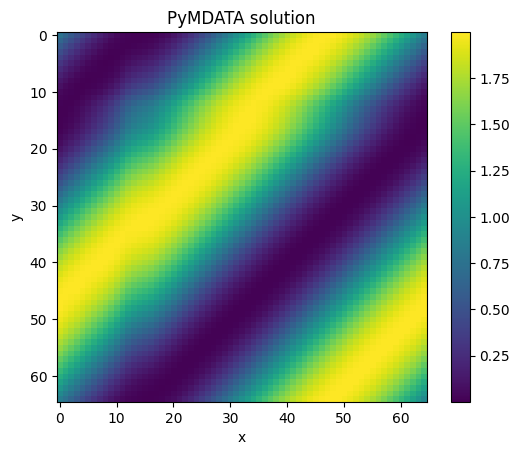

In [14]:
plt.imshow(pympdata_result_state, cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('PyMDATA solution')
show_plot(inline_format='png')

In [15]:
solution_filename = [f for f in os.listdir("./out") if "solution" in f][0]

In [16]:
%%writefile to_vtk.jl
using Trixi2Vtk
trixi2vtk(joinpath("out", ARGS[1]))

Overwriting to_vtk.jl


In [17]:
subprocess.run(["julia", "to_vtk.jl", solution_filename], check=True)

CompletedProcess(args=['julia', 'to_vtk.jl', 'solution_000030.h5'], returncode=0)

In [18]:
try:
    vtu_filename = [f for f in os.listdir("./") if "vtu" in f and "celldata" not in f][0]
    mesh = meshio.read(vtu_filename)
    trixi_points = ((mesh.points[:,:2] + 1)*SETUP["nx"]*SETUP["polydeg"]/2).round().astype(np.int16)
    assert trixi_points.shape[0] == SETUP["nx"]**2 * (SETUP["polydeg"] + 1)**2
except Exception as e:
    e.args += (list(os.walk(os.path.curdir)),)
    raise e

In [19]:
try:
    trixi_output = np.zeros(pympdata_result_state.shape)
    for i in range(trixi_points.shape[0]):
        trixi_output[trixi_points[i][0], trixi_points[i][1]] = mesh.point_data['scalar'][i][0]
except Exception as e:
    e.args += (list(mesh.point_data.keys()),)
    e.args += (list(mesh.points.shape),)
    raise e

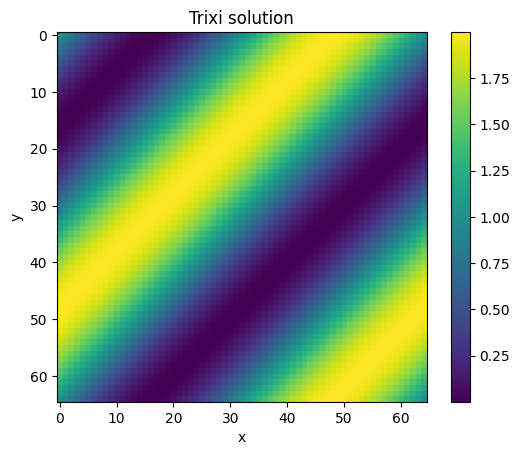

In [20]:
plt.imshow(trixi_output, cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Trixi solution")
show_plot(inline_format='png')

In [21]:
residual = pympdata_result_state - trixi_output
rmse = np.sqrt(np.mean(residual**2))
mse = np.mean(residual**2)
max_diff = np.max(np.abs(residual))
min_diff = np.min(np.abs(residual))

In [22]:
assert np.allclose(rmse, 6.94e-2, 0.1)
assert np.allclose(mse, 4.81e-3, 0.1)
assert np.allclose(max_diff, 0.285, 0.1)
assert np.allclose(min_diff, 2.69e-5, 0.1)